In [ ]:
# ==========================================
# 1. Setup & Load Dataset
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("youth_unemployment_global.csv")
df.columns = df.columns.str.lower().str.strip()

# Detect unemployment column dynamically
unemp_col = None
for col in df.columns:
    if "unemploy" in col:
        unemp_col = col

print("Detected unemployment column:", unemp_col)
df.head()


Detected unemployment column: youthunemployment


,country,countrycode,year,youthunemployment
0,Africa Eastern and Southern,ZH,2024,13.283002
1,Africa Eastern and Southern,ZH,2023,13.367810
2,Africa Eastern and Southern,ZH,2022,13.620217
3,Africa Eastern and Southern,ZH,2021,14.955182
4,Africa Eastern and Southern,ZH,2020,14.997030


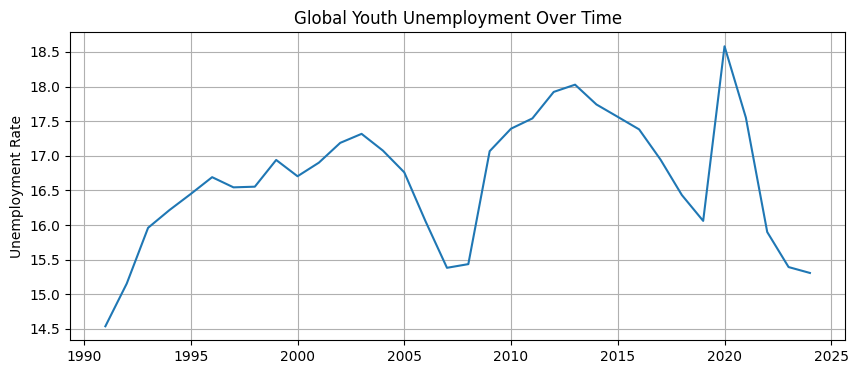

,youthunemployment
year,
1960,NaN
1961,NaN
1962,NaN
1963,NaN
1964,NaN
...,...
2020,18.581163
2021,17.550899
2022,15.898825


In [ ]:
# Build a global average unemployment series
global_ts = df.groupby("year")[unemp_col].mean().sort_index()

plt.figure(figsize=(10,4))
plt.plot(global_ts)
plt.title("Global Youth Unemployment Over Time")
plt.ylabel("Unemployment Rate")
plt.grid(True)
plt.show()

global_ts


In [ ]:
train_size = int(len(global_ts) * 0.8)
train = global_ts.iloc[:train_size]
test = global_ts.iloc[train_size:]


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

# basic ARIMA order
p, d, q = 1, 1, 1

model_arima = ARIMA(train, order=(p, d, q)).fit()
print(model_arima.summary())


                               SARIMAX Results                                
Dep. Variable:      youthunemployment   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -21.270
Date:                Sun, 07 Dec 2025   AIC                             48.540
Time:                        21:48:49   BIC                             54.335
Sample:                             0   HQIC                            50.754
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1108      0.915      0.121      0.904      -1.683       1.905
ma.L1          0.3534      0.966      0.366      0.715      -1.541       2.247
sigma2         0.2221      0.061      3.622      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


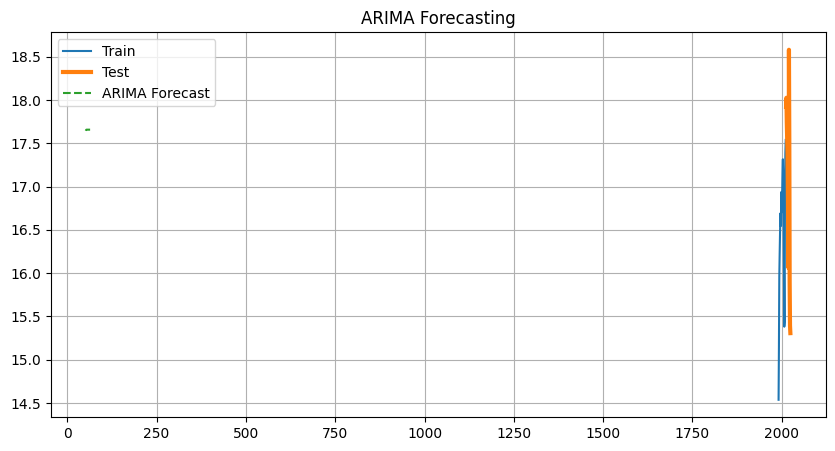

In [ ]:
forecast_arima = model_arima.forecast(steps=len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", linewidth=3)
plt.plot(forecast_arima, label="ARIMA Forecast", linestyle="--")
plt.title("ARIMA Forecasting")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# choose seasonal period (annual cycles) — adjust if needed
s = 5

model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,s)).fit()
print(model_sarima.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                 youthunemployment   No. Observations:                   52
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                 -59.124
Date:                           Sun, 07 Dec 2025   AIC                            128.248
Time:                                   21:49:07   BIC                            137.391
Sample:                                        0   HQIC                           131.673
                                            - 52                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3777      1.276      0.296      0.767      -2.124       2.880
ma.L1          0.2887      1.857      0.155

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


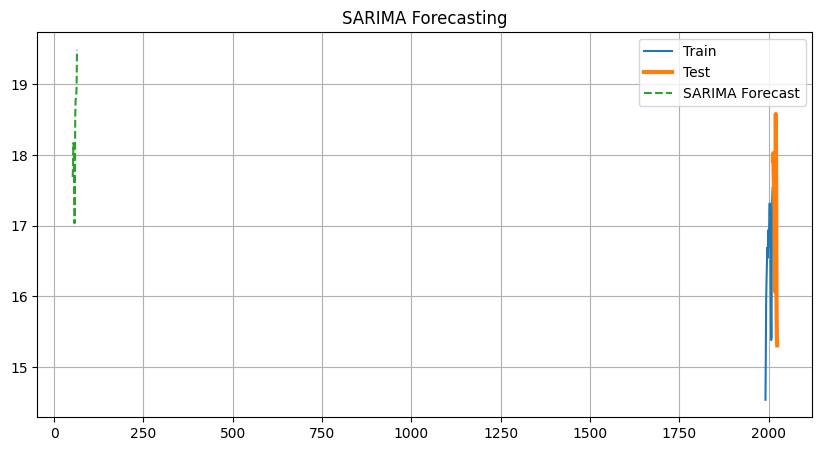

In [ ]:
forecast_sarima = model_sarima.forecast(steps=len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", linewidth=3)
plt.plot(forecast_sarima, label="SARIMA Forecast", linestyle="--")
plt.title("SARIMA Forecasting")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import statsmodels.api as sm

reg_df = global_ts.reset_index()
X = sm.add_constant(reg_df["year"])
y = reg_df[unemp_col]

reg_model = sm.OLS(y, X).fit()
print(reg_model.summary())


                            OLS Regression Results                            
Dep. Variable:      youthunemployment   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 07 Dec 2025   Prob (F-statistic):                nan
Time:                        21:49:39   Log-Likelihood:                    nan
No. Observations:                  65   AIC:                               nan
Df Residuals:                      63   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

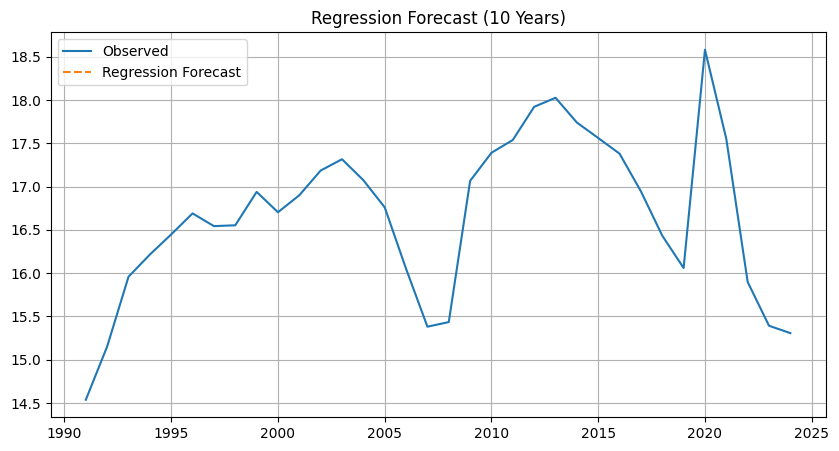

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [ ]:
future_years = pd.DataFrame({
    "year": np.arange(reg_df["year"].max()+1, reg_df["year"].max()+11)
})

future_years_const = sm.add_constant(future_years)
reg_forecast = reg_model.predict(future_years_const)

plt.figure(figsize=(10,5))
plt.plot(reg_df["year"], y, label="Observed")
plt.plot(future_years["year"], reg_forecast, label="Regression Forecast", linestyle="--")
plt.title("Regression Forecast (10 Years)")
plt.legend()
plt.grid(True)
plt.show()

reg_forecast


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn
print("scikit-learn version:", sklearn.__version__)

def evaluate(true, pred):
    true = np.array(true)
    pred = np.array(pred)

    mse = mean_squared_error(true, pred)  # no squared kwarg
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)

    # safe MAPE
    mask = true != 0
    if mask.sum() == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true[mask] - pred[mask]) / true[mask])) * 100

    return rmse, mae, mape

rmse_a, mae_a, mape_a = evaluate(test, forecast_arima)
rmse_s, mae_s, mape_s = evaluate(test, forecast_sarima)

print("ARIMA Performance:")
print("  RMSE:", rmse_a)
print("  MAE :", mae_a)
print("  MAPE:", mape_a)

print("\nSARIMA Performance:")
print("  RMSE:", rmse_s)
print("  MAE :", mae_s)
print("  MAPE:", mape_s)


scikit-learn version: 1.6.1
ARIMA Performance:
  RMSE: 1.2242588165409924
  MAE : 0.9265070049528303
  MAPE: 5.733502101747785

SARIMA Performance:
  RMSE: 1.9156374310018571
  MAE : 1.2976892781065754
  MAPE: 8.129038644884828


In [ ]:
results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA"],
    "RMSE": [rmse_a, rmse_s],
    "MAE": [mae_a, mae_s],
    "MAPE": [mape_a, mape_s]
})

results


,Model,RMSE,MAE,MAPE
0,ARIMA,1.224259,0.926507,5.733502
1,SARIMA,1.915637,1.297689,8.129039
